# import
0. 读取数据、矩阵计算
--------
1. 正则去标点等+大小写
2. 空格分词+去停用词
3. 词形统一
3. tf-idf编码方式
--------
4. 模型：贝叶斯、决策树、随机森林、SVM、逻辑回归
5. 分析：混淆矩阵、准确率预测、训练耗时
6. 保存模型

In [17]:
import csv
import numpy as np
import matplotlib.pyplot as plt

import nltk
import re
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

import time
import pickle

# 读取数据集
使用csv读取文本文件，得到二维列表

In [2]:
"""获取原始数据"""
file_path = '../smsspamcollection/SMSSpamCollection'
smsFile = open(file_path, 'r', encoding='utf-8') ## 返回文件对象
sms = csv.reader(smsFile, delimiter='\t') ## 第一层：行列表；第二层：列列表
sms = list(sms) 
smsFile.close()
"""显示原始数据"""
for line in sms[0:3]:
    print(line)

['ham', 'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...']
['ham', 'Ok lar... Joking wif u oni...']
['spam', "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]


# 预处理
## 定义预处理

In [3]:
def regUse(text):
    text = re.sub(r"[,.?!\":]", '', text) # 去标点
    text = re.sub(r"'\w*\s", ' ', text) # 去缩写
    text = re.sub(r"#?&.{1,3};", '', text) # 去html符号
    return text.lower()
def sampleSeg(text):
    tokens = [word for word in word_tokenize(text) if word not in stopwords.words('english') and len(word)>=3]
    return tokens
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
def lemSeg(tokens):
    res = []
    lemmatizer = WordNetLemmatizer()
    for word, pos in pos_tag(tokens):
        wordnet_pos = get_wordnet_pos(pos) or wordnet.NOUN
        res.append(lemmatizer.lemmatize(word, pos=wordnet_pos))

    return res
def preprocess(text):
    text = regUse(text)
    tokens = sampleSeg(text)
    tokens = lemSeg(tokens)
    return tokens ## 返回的是单词列表

## 实施预处理

In [5]:
sms_data = [] ## 每个元素是一个句子
sms_label = [] ## 每个元素是一个字符串"ham"/"spam"
start = time.perf_counter()
for line in sms:
    sms_data.append(" ".join(preprocess(line[1])))
    sms_label.append(line[0])
elapsed = (time.perf_counter() - start)
print("预处理耗时:{:.2f}s".format(elapsed))
"""显示预处理结果"""
print("预处理后的结果示例：")
print(sms_data[0:3])
print(sms_label[0:3])

预处理耗时:43.13s
预处理后的结果示例：
['jurong point crazy available bugis great world buffet cine get amore wat', 'lar joking wif oni', 'free entry wkly comp win cup final tkts 21st may 2005 text 87121 receive entry question std txt rate apply 08452810075over18']
['ham', 'ham', 'spam']


# 得到训练集、测试集
## raw形式

In [6]:
size_dataset = len(sms_data)
size_trainset = int(round(size_dataset*0.7))
print('dataset规模:{}行, trainset规模:{}行, testset规模:{}行\n'.format(size_dataset, size_trainset, size_dataset-size_trainset))

x_train = np.array(sms_data[0:size_trainset])
y_train = np.array(sms_label[0:size_trainset])

x_test = np.array(sms_data[size_trainset+1: size_dataset])
y_test = np.array(sms_label[size_trainset+1: size_dataset])

print("raw形式示例：")
print(x_train[0:1])
print(y_train[0:1])

dataset规模:5572行, trainset规模:3900行, testset规模:1672行

raw形式示例：
['jurong point crazy available bugis great world buffet cine get amore wat']
['ham']


## 向量形式

In [7]:
vectorizer=TfidfVectorizer(min_df=2,ngram_range=(1,2),stop_words='english',strip_accents='unicode',norm='l2')
 
x_train=vectorizer.fit_transform(x_train) #fit+标准化
x_test=vectorizer.transform(x_test) #仅标准化即可

print("稀疏矩阵示例：")
print(x_train[0:1])
print("稠密矩阵示例：")
print(x_train[0:1].todense())

稀疏矩阵示例：
  (0, 3696)	0.31363210229069505
  (0, 1368)	0.348820693452981
  (0, 738)	0.344403438565091
  (0, 981)	0.3717663537353778
  (0, 2182)	0.252742012566388
  (0, 5403)	0.29960771122339475
  (0, 980)	0.4147806208896629
  (0, 1152)	0.36498744484823614
  (0, 5222)	0.25344224995737386
稠密矩阵示例：
[[0. 0. 0. ... 0. 0. 0.]]


# 开始分类
## 通用函数

In [31]:
def save_model(clf, name):
    file_path = './' + name + '.pkl'
    with open(file_path, 'wb') as f:
        pickle.dump(clf, f)
    print(name + "模型保存成功")
        
def get_model(name):
    file_path = './' + name + '.pkl'
    try:
        with open(file_path,'rb') as f:
          return pickle.load(f)
    except EOFError: #捕获异常EOFError 后返回None
        print('错误：尝试读取空文件')
        return None   
    
def show_model(y_test, y_pred, name):
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    print(name + '的混淆矩阵：')
    print(cm)
    print(name + '的分类结果：')
    print(cr)

def print_AUC(clf,x_test,y_test):
    y_probas = cross_val_predict(clf, x_test, y_test, cv=3, method="predict_proba")
    y_scores = y_probas[:, 1]
    fpr,tpr,threshold = roc_curve(y_test,y_scores,pos_label='spam')
    roc_auc = auc(fpr,tpr)
 
    plt.figure()
    lw = 2
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
def print_AUC_svm(clf,x_test,y_test):
    y_score = clf.decision_function(x_test)

    fpr,tpr,threshold = roc_curve(y_test,y_score,pos_label='spam')
    roc_auc = auc(fpr,tpr)
 
    plt.figure()
    lw = 2
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

## 朴素贝叶斯

MultinomialNB训练耗时:0.01s
MultinomialNB的混淆矩阵：
[[1439    4]
 [  64  164]]
MultinomialNB的分类结果：
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1443
        spam       0.98      0.72      0.83       228

   micro avg       0.96      0.96      0.96      1671
   macro avg       0.97      0.86      0.90      1671
weighted avg       0.96      0.96      0.96      1671

MultinomialNB模型保存成功


<Figure size 432x288 with 0 Axes>

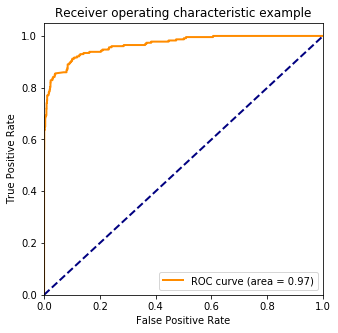

In [21]:
"""训练"""
start = time.perf_counter()
clf = MultinomialNB().fit(x_train, y_train)
elapsed = (time.perf_counter() - start)
print("MultinomialNB训练耗时:{:.2f}s".format(elapsed))
"""预测"""
y_nb_pred = clf.predict(x_test)
"""结果显示"""
show_model(y_test, y_nb_pred, "MultinomialNB")
"""保存模型"""
save_model(clf, "MultinomialNB")

print_AUC(clf,x_test,y_test)

## 决策树

DecisionTree训练耗时:16.80s
DecisionTree的混淆矩阵：
[[1414   29]
 [  49  179]]
DecisionTree的分类结果：
              precision    recall  f1-score   support

         ham       0.97      0.98      0.97      1443
        spam       0.86      0.79      0.82       228

   micro avg       0.95      0.95      0.95      1671
   macro avg       0.91      0.88      0.90      1671
weighted avg       0.95      0.95      0.95      1671

DecisionTree模型保存成功


<Figure size 432x288 with 0 Axes>

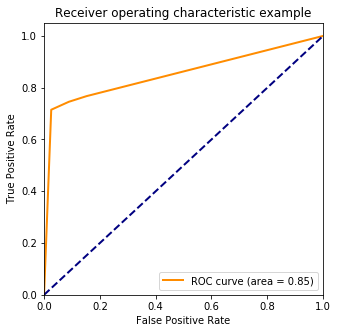

In [22]:
"""训练"""
start = time.perf_counter()
clf = tree.DecisionTreeClassifier().fit(x_train.toarray(), y_train)
elapsed = (time.perf_counter() - start)
print("DecisionTree训练耗时:{:.2f}s".format(elapsed))
"""预测"""
y_tree_pred = clf.predict(x_test.toarray())
"""结果显示"""
show_model(y_test, y_tree_pred, "DecisionTree")
"""保存模型"""
save_model(clf, "DecisionTree")

y_probas = cross_val_predict(clf, x_test, y_test, cv=3, method="predict_proba")
y_scores = y_probas[:, 1]
fpr,tpr,threshold = roc_curve(y_test,y_scores,pos_label='spam')
roc_auc = auc(fpr,tpr)
 
print_AUC(clf,x_test,y_test)

## 随机森林

RandomForest训练耗时:0.10s
RandomForest的混淆矩阵：
[[1440    3]
 [  50  178]]
RandomForest的分类结果：
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98      1443
        spam       0.98      0.78      0.87       228

   micro avg       0.97      0.97      0.97      1671
   macro avg       0.97      0.89      0.93      1671
weighted avg       0.97      0.97      0.97      1671

RandomForest模型保存成功


<Figure size 432x288 with 0 Axes>

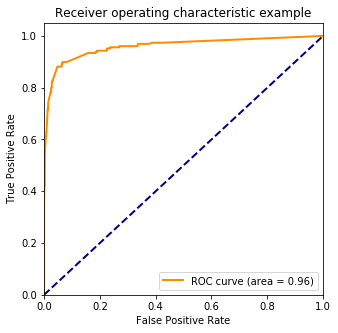

In [27]:
"""训练"""
start = time.perf_counter()
clf = RandomForestClassifier(n_estimators=10)
clf.fit(x_train, y_train)
elapsed = (time.perf_counter() - start)
print("RandomForest训练耗时:{:.2f}s".format(elapsed))
"""预测"""
y_RF_pred = clf.predict(x_test)
"""结果显示"""
show_model(y_test, y_RF_pred, "RandomForest")
"""保存模型"""
save_model(clf, "RandomForest")

print_AUC(clf,x_test,y_test)

## 线性SVC

LinearSVC训练耗时:0.01s
LinearSVC的混淆矩阵：
[[1436    7]
 [  30  198]]
LinearSVC的分类结果：
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1443
        spam       0.97      0.87      0.91       228

   micro avg       0.98      0.98      0.98      1671
   macro avg       0.97      0.93      0.95      1671
weighted avg       0.98      0.98      0.98      1671

LinearSVC模型保存成功


<Figure size 432x288 with 0 Axes>

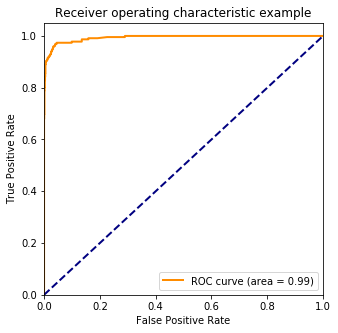

In [32]:
"""训练"""
start = time.perf_counter()
clf = LinearSVC().fit(x_train, y_train)
elapsed = (time.perf_counter() - start)
print("LinearSVC训练耗时:{:.2f}s".format(elapsed))
"""预测"""
y_svm_pred = clf.predict(x_test)
"""结果显示"""
show_model(y_test, y_svm_pred, "LinearSVC")
"""保存模型"""
save_model(clf, "LinearSVC")

print_AUC_svm(clf,x_test,y_test)

## 非线性SVM

SGDsvm训练耗时:0.02s
SGDsvm的混淆矩阵：
[[1434    9]
 [  29  199]]
SGDsvm的分类结果：
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99      1443
        spam       0.96      0.87      0.91       228

   micro avg       0.98      0.98      0.98      1671
   macro avg       0.97      0.93      0.95      1671
weighted avg       0.98      0.98      0.98      1671

SGDsvm模型保存成功


C:\Users\ACER\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


<Figure size 432x288 with 0 Axes>

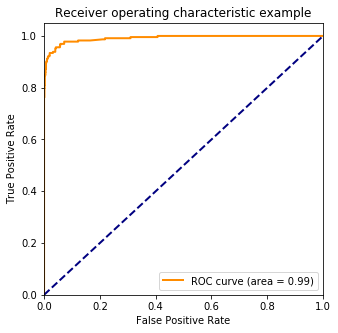

In [33]:
"""训练"""
start = time.perf_counter()
clf=SGDClassifier(alpha=0.0001,n_iter=50).fit(x_train, y_train)
elapsed = (time.perf_counter() - start)
print("SGDsvm训练耗时:{:.2f}s".format(elapsed))
"""预测"""
y_SGDsvm_pred = clf.predict(x_test)
"""结果显示"""
show_model(y_test, y_SGDsvm_pred, "SGDsvm")
"""保存模型"""
save_model(clf, "SGDsvm")

print_AUC_svm(clf,x_test,y_test)

## 逻辑回归

SGDlog训练耗时:0.04s
SGDlog的混淆矩阵：
[[1436    7]
 [  37  191]]
SGDlog的分类结果：
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98      1443
        spam       0.96      0.84      0.90       228

   micro avg       0.97      0.97      0.97      1671
   macro avg       0.97      0.92      0.94      1671
weighted avg       0.97      0.97      0.97      1671

SGDlog模型保存成功


C:\Users\ACER\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Users\ACER\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Users\ACER\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Users\ACER\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


<Figure size 432x288 with 0 Axes>

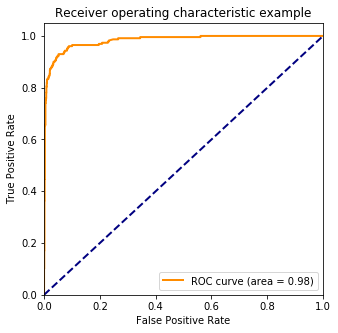

In [25]:
"""训练"""
start = time.perf_counter()
clf=SGDClassifier(loss='log', alpha=0.0001,n_iter=50).fit(x_train, y_train)
elapsed = (time.perf_counter() - start)
print("SGDlog训练耗时:{:.2f}s".format(elapsed))
"""预测"""
y_SGDlog_pred = clf.predict(x_test)
"""结果显示"""
show_model(y_test, y_SGDlog_pred, "SGDlog")
"""保存模型"""
save_model(clf, "SGDlog")

print_AUC(clf,x_test,y_test)

# 完成嘻嘻